Dataset

In [1]:
#! pip install opendatasets

In [6]:
import opendatasets as od

In [3]:
# Download The Dataset
od.download('https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data')

Skipping, found downloaded files in ".\brain-tumor-mri-dataset" (use force=True to force download)


In [7]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [4]:
# Prepare The Training Data

transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder("brain-tumor-mri-dataset/Training", transform=transformer)

train_len = int(len(dataset) * 0.8)
val_len = len(dataset) - train_len

train_data, val_data = random_split(dataset, [train_len, val_len]) # seperate the train data from validation

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

In [5]:
# See the mapping between the classes name and classes id
dataset.class_to_idx

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [6]:
train_idx = []
for _, label in train_loader:
    train_idx.extend(label.tolist())

In [7]:
mapper = {j : i for i,j in dataset.class_to_idx.items()}
train_dist = {}
for id in train_idx:
    train_dist[mapper[id]] = train_dist.get(mapper[id], 0) + 1

In [8]:
# Train data statistics
print(f"The Training Set size is {len(train_idx)}")
print("_" * 35)
print(f"The repartition of classes :")
print("\n".join([f"{i} : {j}" for i,j in train_dist.items()]))
print("_" * 35)
print(f"Percentage of each class :")
print("\n".join([f"{i} : {round(j/len(train_idx),2)}" for i,j in train_dist.items()]))


The Training Set size is 4569
___________________________________
The repartition of classes :
glioma : 1045
pituitary : 1176
notumor : 1273
meningioma : 1075
___________________________________
Percentage of each class :
glioma : 0.23
pituitary : 0.26
notumor : 0.28
meningioma : 0.24


In [3]:
import matplotlib.pyplot as plt
import numpy as np

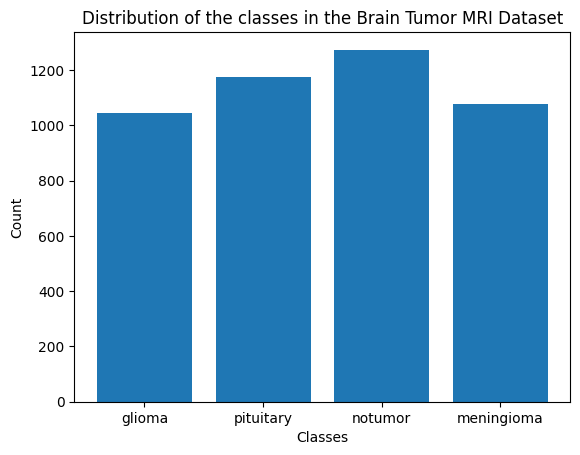

In [34]:
# Plot The distribution
plt.bar(train_dist.keys(), train_dist.values())
plt.title("Distribution of the classes in the Brain Tumor MRI Dataset")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

In [35]:
val_idx = []
for _, label in val_loader:
    val_idx.extend(label.tolist())

In [36]:
val_dist = {}
for id in val_idx:
    val_dist[mapper[id]] = val_dist.get(mapper[id], 0) + 1

In [37]:
dist = {i : [j, val_dist[i]] for i,j in train_dist.items()}

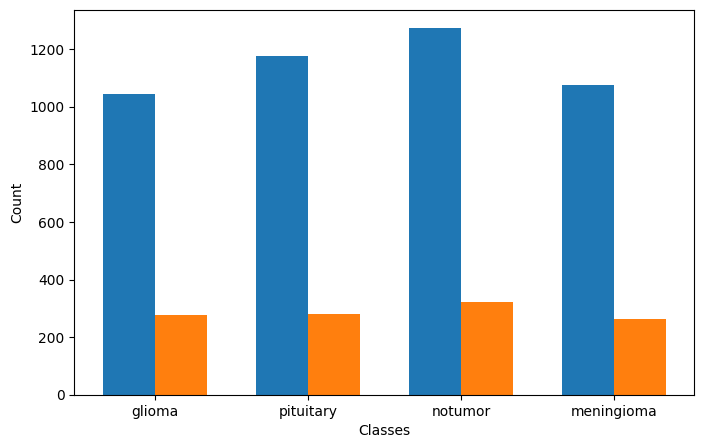

In [38]:
# Plot The distribution
plt.figure(figsize=(8,5))
plt.bar([i - 0.17 for i in range(4)], [i[0] for i in list(dist.values())], 0.34)
plt.bar([i + 0.17 for i in range(4)], [i[1] for i in list(dist.values())], 0.34)
plt.xticks(range(4), dist.keys())
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

In [2]:
import torch
from torch import nn
from torchvision import models
from torch.optim import Adam
import torch.nn.functional as F


In [9]:
def efficientNet_model(model_name = "efficientnet_b0",  num_classes = 4, pretrained = True):


    if model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=pretrained)
    elif model_name == "efficientnet_b1":
        model = models.efficientnet_b1(pretrained=pretrained)
    elif model_name == "efficientnet_b2":
        model = models.efficientnet_b2(pretrained=pretrained)
    else:
        raise ValueError(f"Unsupported EfficientNet version: {model_name}")

    # Replace classifier head
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features, in_features * 2),
        nn.GELU(),
        nn.Linear(in_features * 2, num_classes)
    )

    return model

In [10]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += imgs.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

In [42]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            total_correct += (preds == labels).sum().item()
            total_samples += imgs.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [49]:
n_classes = 4
epochs = 5

In [50]:
model = efficientNet_model("efficientnet_b0", num_classes= n_classes, pretrained=True)
params = torch.load("last_model.pth")
model.load_state_dict(params)
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [51]:
# freezing backbone
for param in model.features.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)
#optimizer_state = torch.load("last_optimizer.pth")
#optimizer.load_state_dict(optimizer_state)

In [52]:
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

In [53]:
best_acc = 0
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"  Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Best val acc:", best_acc)

Epoch [1/5]
  Train Loss: 0.4017 | Acc: 0.8746
  Val   Loss: 0.1733 | Acc: 0.9361
Epoch [2/5]
  Train Loss: 0.1689 | Acc: 0.9479
  Val   Loss: 0.1319 | Acc: 0.9466
Epoch [3/5]
  Train Loss: 0.0775 | Acc: 0.9726
  Val   Loss: 0.0967 | Acc: 0.9694
Epoch [4/5]
  Train Loss: 0.0992 | Acc: 0.9676
  Val   Loss: 0.0737 | Acc: 0.9720
Epoch [5/5]
  Train Loss: 0.0991 | Acc: 0.9713
  Val   Loss: 0.0585 | Acc: 0.9764
Best val acc: 0.9763779527559056


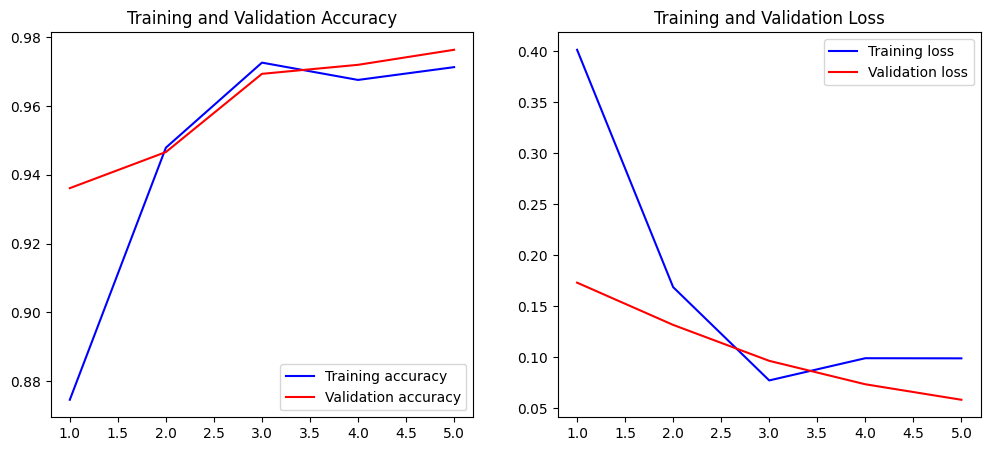

In [54]:
train_acc = history['train_acc']
val_acc = history['val_acc']
train_loss = history['train_loss']
val_loss = history['val_loss']
e = range(1, len(train_acc) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(e, train_acc, 'b', label='Training accuracy')
plt.plot(e, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(e, train_loss, 'b', label='Training loss')
plt.plot(e, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [55]:
testset = ImageFolder("brain-tumor-mri-dataset/Testing", transform=transformer)
test_loader = DataLoader(testset)

In [56]:
testset.class_to_idx

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [57]:
correct = 0
total = 0

with torch.no_grad():  # disable gradient calculation
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)               # raw logits
        preds = torch.argmax(outputs, dim=1) # predicted class

        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 97.86%


In [58]:
# save the model and optimizer last state
torch.save(model.state_dict(), "last_model.pth")
torch.save(optimizer.state_dict(), "last_optimizer.pth")

## GradCAM

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, transforms
import gc
import os


In [2]:
# Constants
CLASS_NAMES = ["Glioma", "Meningioma", "Pituitary", "No Tumor"]
PREPROCESSING_MODE = "imagenet"  # same default as in app
MODEL_PATH = "last_model.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
def efficientNet_model(model_name="efficientnet_b0", num_classes=4, pretrained=True):
    """
    Same architecture as in your Streamlit app:
    EfficientNet-B0 with custom classifier:
      Dropout -> Linear(in, in*2) -> GELU -> Linear(in*2, num_classes)
    """
    if model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=pretrained)
    elif model_name == "efficientnet_b1":
        model = models.efficientnet_b1(pretrained=pretrained)
    elif model_name == "efficientnet_b2":
        model = models.efficientnet_b2(pretrained=pretrained)
    elif model_name == "efficientnet_b3":
        model = models.efficientnet_b3(pretrained=pretrained)
    else:
        raise ValueError(f"Unsupported EfficientNet version: {model_name}")

    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features, in_features * 2),
        nn.GELU(),
        nn.Linear(in_features * 2, num_classes)
    )
    return model


In [4]:
def load_model(model_path=MODEL_PATH):
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model = efficientNet_model("efficientnet_b0", num_classes=4, pretrained=False)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model

model = load_model()
print("Model loaded from:", MODEL_PATH)


C:\Users\gaming\anaconda3\envs\torch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gaming\anaconda3\envs\torch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\gaming\AppData\Local\Temp\ipykernel_28144\2234637163.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value 

Model loaded from: last_model.pth


In [5]:
def preprocess_image(image: Image.Image, use_imagenet_norm=True):
    """
    Preprocess image for EfficientNet.
    """
    transform_list = [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
    
    if use_imagenet_norm:
        transform_list.append(
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        )
    
    transform = transforms.Compose(transform_list)
    tensor = transform(image).unsqueeze(0)  # (1, 3, 224, 224)
    return tensor


In [6]:
class ReliableGradCAM:
    def __init__(self, model, target_layer, cam_size=(224, 224)):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.forward_handle = None
        self.backward_handle = None
        self.cam_size = cam_size

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        # grad_output[0] = gradient w.r.t. module output
        self.gradients = grad_output[0].detach()

    def __call__(self, x):
        # Register hooks
        self.forward_handle = self.target_layer.register_forward_hook(self.save_activation)
        self.backward_handle = self.target_layer.register_full_backward_hook(self.save_gradient)

        try:
            # Forward
            output = self.model(x)  # (N, num_classes)

            # Clear old grads
            self.model.zero_grad()

            # One-hot on predicted class
            pred = output.argmax(dim=1)
            one_hot = torch.zeros_like(output)
            one_hot[0, pred] = 1

            # Backward to get gradients
            output.backward(gradient=one_hot)

            if self.gradients is None or self.activations is None:
                raise ValueError("Failed to capture gradients or activations")

            # Grad-CAM
            # gradients, activations: (N, C, H, W)
            weights = F.adaptive_avg_pool2d(self.gradients, 1)  # (N, C, 1, 1)
            cam = torch.sum(weights * self.activations, dim=1, keepdim=True)  # (N, 1, H, W)
            cam = F.relu(cam)

            # Resize to input spatial size
            cam = F.interpolate(cam, size=self.cam_size, mode='bilinear', align_corners=False)

            # Normalize 0–1
            cam_min = cam.min()
            cam_max = cam.max()
            cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)

            return cam.squeeze().cpu().numpy(), pred.item()

        finally:
            # Remove hooks
            if self.forward_handle is not None:
                self.forward_handle.remove()
            if self.backward_handle is not None:
                self.backward_handle.remove()


In [7]:
def make_gradcam_overlay(original_image: Image.Image,
                         preprocessed_tensor: torch.Tensor,
                         model,
                         use_imagenet_norm=True):
    """
    Generate Grad-CAM overlay on the original image using ReliableGradCAM.
    """
    device = next(model.parameters()).device
    preprocessed_tensor = preprocessed_tensor.to(device)

    # Target layer: last feature block (same as app)
    target_layer = model.features[-1]
    gradcam = ReliableGradCAM(model, target_layer, cam_size=(224, 224))
    cam, pred_idx = gradcam(preprocessed_tensor)

    # Resize original to 224x224
    img_resized = original_image.resize((224, 224))
    img_np = np.array(img_resized).astype(np.float32) / 255.0

    # Colorize heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    # Overlay
    overlay = 0.5 * heatmap + 0.5 * img_np
    overlay = np.clip(overlay, 0, 1)
    overlay_uint8 = (overlay * 255).astype(np.uint8)
    overlay_img = Image.fromarray(overlay_uint8)

    return overlay_img, pred_idx


Full path to MRI image:  C:\Users\gaming\Desktop\NoteBooks\archive\Testing\glioma\Te-gl_0014.jpg



Prediction: Glioma (class 0)
Confidence: 100.00%

Class probabilities:
  0 - Glioma: 100.00%
  1 - Meningioma: 0.00%
  2 - Pituitary: 0.00%
  3 - No Tumor: 0.00%


C:\Users\gaming\anaconda3\envs\torch_env\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


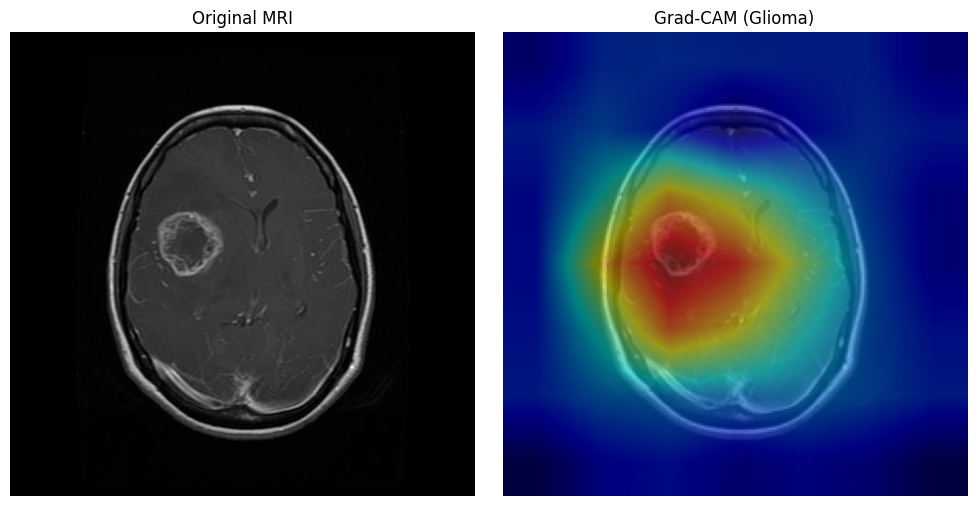

In [9]:
# Very simple: paste the full path to your image
img_path = input("Full path to MRI image: ").strip()

if not os.path.isfile(img_path):
    raise FileNotFoundError(f"Image not found: {img_path}")

# Load image
image = Image.open(img_path).convert("RGB")

# Preprocess
use_imagenet_preprocessing = (PREPROCESSING_MODE == "imagenet")
input_tensor = preprocess_image(image, use_imagenet_norm=use_imagenet_preprocessing)

# Run through model for probabilities
with torch.no_grad():
    outputs = model(input_tensor.to(device))
    probs = F.softmax(outputs, dim=1)[0].cpu().numpy()

pred_idx = int(np.argmax(probs))
pred_name = CLASS_NAMES[pred_idx]
pred_conf = float(probs[pred_idx])

print(f"\nPrediction: {pred_name} (class {pred_idx})")
print(f"Confidence: {pred_conf*100:.2f}%\n")

print("Class probabilities:")
for i, (name, p) in enumerate(zip(CLASS_NAMES, probs)):
    print(f"  {i} - {name}: {p*100:.2f}%")

# Grad-CAM overlay
overlay_img, cam_pred_idx = make_gradcam_overlay(
    original_image=image,
    preprocessed_tensor=input_tensor,
    model=model,
    use_imagenet_norm=use_imagenet_preprocessing
)

# Show original and overlay
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original MRI")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay_img)
plt.title(f"Grad-CAM ({CLASS_NAMES[cam_pred_idx]})")
plt.axis("off")

plt.tight_layout()
plt.show()


## Confusion Matrix

In [11]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


In [12]:
# Path to your test set (with subfolders: Glioma, Meningioma, Pituitary, No Tumor, etc.)
TEST_DIR = r"C:\Users\gaming\Desktop\NoteBooks\archive\Testing"  # <-- ADAPT THIS

# Same transforms as for training / Grad-CAM (ImageNet normalization)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

test_dataset = ImageFolder(TEST_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Test classes from folder:", test_dataset.classes)
print("Number of test images:", len(test_dataset))


Test classes from folder: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of test images: 1311


In [13]:
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

accuracy = (all_labels == all_preds).mean()
print(f"Overall accuracy on test set: {accuracy*100:.2f}%")


Overall accuracy on test set: 97.79%


Confusion matrix (raw counts):
[[291   4   4   1]
 [  9 291   0   6]
 [  0   1 401   3]
 [  0   1   0 299]]


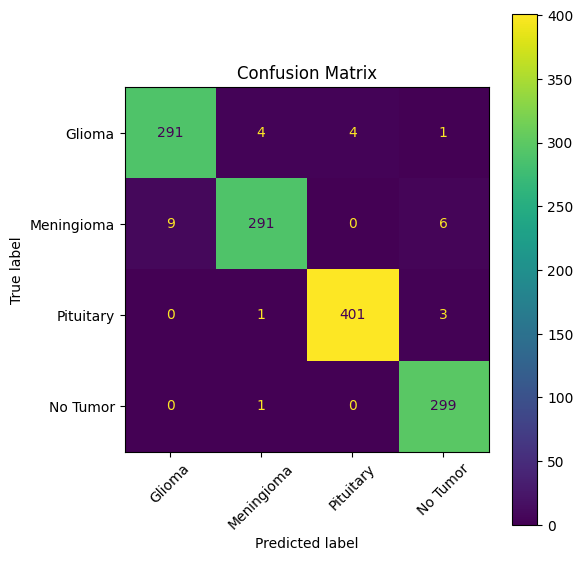


Classification report:
              precision    recall  f1-score   support

      Glioma       0.97      0.97      0.97       300
  Meningioma       0.98      0.95      0.97       306
   Pituitary       0.99      0.99      0.99       405
    No Tumor       0.97      1.00      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [14]:
# Choose label names: either CLASS_NAMES or test_dataset.classes
if len(CLASS_NAMES) == len(test_dataset.classes):
    label_names = CLASS_NAMES
else:
    label_names = test_dataset.classes
    print("⚠ Using test_dataset.classes as labels:", label_names)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

print("Confusion matrix (raw counts):")
print(cm)

# Pretty plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Detailed metrics per class
print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=label_names))
